In [1]:
import os
from os.path import abspath

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions as F

import datetime

os.environ['PYSPARK_SUBMIT_ARGS'] = ' --driver-memory 7g --executor-memory 7g pyspark-shell'

warehouse_location = abspath('spark-warehouse')
spark = SparkSession.builder.config("spark.sql.warehouse.dir", warehouse_location).appName("SparkSQL").getOrCreate()


def log2row(line):    
    fields = line.split(',')
    row_eid = int(fields[0])
    row_source = fields[2]
    row_event = fields[3]
    row_object = fields[4]
    t = fields[1].split('T')
    r_date = t[0].split('-')
    r_time = t[1].split(':')
    row_date = datetime.datetime(int(r_date[0]), int(r_date[1]), int(r_date[2]), 0, 0, 0)
    row_time = datetime.datetime(1990, 1, 1, int(r_time[0]), int(r_time[1]), int(r_time[2]))
    return Row(enrollment_id = row_eid, date = row_date, time = row_time, source = row_source, event = row_event, object_id = row_object )


def true2row(line):
    fields = line.split(',')
    row_eid = int(fields[0])
    row_dropout = bool(int(fields[1]))
    return Row(enrollment_id = row_eid, dropout = row_dropout)
    
    
def date2row(line):
    fields = line.split(',')
    row_cid = fields[0]
    r_from = fields[1].split('-')
    r_to = fields[2].split('-')
    row_from = datetime.datetime(int(r_from[0]), int(r_from[1]), int(r_from[2]), 0, 0, 0)
    row_to = datetime.datetime(int(r_to[0]), int(r_to[1]), int(r_to[2]), 0, 0, 0)    
    return Row(course_id = row_cid, fromdate = row_from, todate = row_to) 

def enrollment2row(line):
    fields = line.split(',')
    row_eid = int(fields[0])
    row_username = fields[1]
    row_cid = fields[2]
    return Row(enrollment_id = row_eid, username = row_username, course_id = row_cid)
  
    
def object2row(line):
    fields = line.split(',')
    if len(fields) == 5:    
        row_cid = fields[0]
        row_mid = fields[1]
        row_category = fields[2]
        row_children = fields[3]
        row_date = datetime.datetime(1990, 1, 1, 0, 0, 0)
        row_time = datetime.datetime(1990, 1, 1, 0, 0, 0)
        if fields[4] != "null":
            t = fields[4].split('T')
            r_date = t[0].split('-')
            r_time = t[1].split(':')
            row_date = datetime.datetime(int(r_date[0]), int(r_date[1]), int(r_date[2]), 0, 0, 0)
            row_time = datetime.datetime(1990, 1, 1, int(r_time[0]), int(r_time[1]), int(r_time[2]))
        return Row(course_id = row_cid, module_id = row_mid, category = row_category, children=row_children, date=row_date, time=row_time)
    elif len(fields) == 4:
        row_cid = fields[0]
        row_mid = fields[1]
        row_category = fields[2]
        row_children = ""        
        row_date = datetime.datetime(1990, 1, 1, 0, 0, 0)
        row_time = datetime.datetime(1990, 1, 1, 0, 0, 0)
        if fields[3] != "null":
            t = fields[3].split('T')
            r_date = t[0].split('-')
            r_time = t[1].split(':')
            row_date = datetime.datetime(int(r_date[0]), int(r_date[1]), int(r_date[2]), 0, 0, 0)
            row_time = datetime.datetime(1990, 1, 1, int(r_time[0]), int(r_time[1]), int(r_time[2]))
        return Row(course_id = row_cid, module_id = row_mid, category = row_category, children=row_children, date=row_date, time=row_time)    
   
    

    

#csv to DataFrame & register the DataFrames as tables
log_table = spark.sparkContext.textFile("Data/log.csv")
log_head = log_table.first()
log_table_no_header = log_table.filter(lambda x : x != log_head)


true_table = spark.sparkContext.textFile("Data/truth_train.csv")
true_head = true_table.first()
true_table_no_header = true_table.filter(lambda x : x != true_head)


date_table = spark.sparkContext.textFile("Data/date.csv")
date_head = date_table.first()
date_table_no_header = date_table.filter(lambda x : x != date_head)


enrollment_table = spark.sparkContext.textFile("Data/enrollment.csv")
enrollment_head = enrollment_table.first()
enrollment_table_no_header = enrollment_table.filter(lambda x : x != enrollment_head)

object_table = spark.sparkContext.textFile("Data/object.csv")
object_head = object_table.first()
object_table_no_header = object_table.filter(lambda x : x != object_head)





log_rows = log_table_no_header.map(log2row);
true_rows = true_table_no_header.map(true2row);
date_rows = date_table_no_header.map(date2row);
enrollment_rows = enrollment_table_no_header.map(enrollment2row);
object_rows = object_table_no_header.map(object2row);





log_df = spark.createDataFrame(log_rows).cache()
# log_df.createOrReplaceTempView("log_t")

true_df = spark.createDataFrame(true_rows).cache()
# true_df.createOrReplaceTempView("true_t")

date_df = spark.createDataFrame(date_rows).cache()
# date_df.createOrReplaceTempView("date_t")

enrollment_df = spark.createDataFrame(enrollment_rows).cache()
# enrollment_df.createOrReplaceTempView("enrollment_t")

object_df = spark.createDataFrame(object_rows).cache()
# object_df.createOrReplaceTempView("object_t")

date_new_df = date_df.withColumn('days', F.datediff('todate', 'fromdate'))
# date_new_df.agg(F.min('days'), F.max('days')).show()

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

joined_df = log_df.join(enrollment_df, 'enrollment_id')\
                  .join(date_df, 'course_id')\
                  .withColumn('days', F.datediff('todate', 'date'))\
                  .withColumn('hour', F.hour('time'))

courseStringIndexer = StringIndexer(inputCol="course_id", outputCol="courseIndex")
indexed_df = courseStringIndexer.fit(joined_df).transform(joined_df)\
                                .withColumn('courseIndex', F.col('courseIndex').cast('int'))
indexed_df.createOrReplaceTempView('joined_t')

event_encode = spark.sql('''
    SELECT enrollment_id,
        days,
        hour,
        sum(CASE WHEN event = "discussion" THEN count_event ELSE 0 END) c_discusion,
        sum(CASE WHEN event = "wiki" THEN count_event ELSE 0 END) c_wiki,
        sum(CASE WHEN event = "page_close" THEN count_event ELSE 0 END) c_page_close,
        sum(CASE WHEN event = "access" THEN count_event ELSE 0 END) c_access,
        sum(CASE WHEN event = "video" THEN count_event ELSE 0 END) c_video,
        sum(CASE WHEN event = "navigate" THEN count_event ELSE 0 END) c_navigate,
        sum(CASE WHEN event = "problem" THEN count_event ELSE 0 END) c_problem 
    FROM 
        (SELECT enrollment_id, days, hour, event, count(*) as count_event
        FROM joined_t 
        GROUP BY enrollment_id, days, hour, event) 
    GROUP BY enrollment_id, days, hour
    ORDER BY enrollment_id, days, hour
''').cache()

source_encode = spark.sql('''
    SELECT enrollment_id, 
        days, 
        hour,
        sum(CASE WHEN source = "browser" THEN count_event ELSE 0 END) s_browser,
        sum(CASE WHEN source = "server" THEN count_event ELSE 0 END) s_server
    FROM 
        (SELECT enrollment_id, days, hour, source, count(*) as count_event 
        FROM joined_t 
        GROUP BY enrollment_id, days, hour, source)
    GROUP BY enrollment_id, days, hour
    ORDER BY enrollment_id, days, hour
 ''').cache()

course_encode = spark.sql('''
    SELECT enrollment_id, 
        days,
        hour,
        sum(CASE WHEN courseIndex = 0 THEN count_course ELSE 0 END) course0,
        sum(CASE WHEN courseIndex = 1 THEN count_course ELSE 0 END) course1,
        sum(CASE WHEN courseIndex = 2 THEN count_course ELSE 0 END) course2,
        sum(CASE WHEN courseIndex = 3 THEN count_course ELSE 0 END) course3,
        sum(CASE WHEN courseIndex = 4 THEN count_course ELSE 0 END) course4,
        sum(CASE WHEN courseIndex = 5 THEN count_course ELSE 0 END) course5,
        sum(CASE WHEN courseIndex = 6 THEN count_course ELSE 0 END) course6,
        sum(CASE WHEN courseIndex = 7 THEN count_course ELSE 0 END) course7,
        sum(CASE WHEN courseIndex = 8 THEN count_course ELSE 0 END) course8,
        sum(CASE WHEN courseIndex = 9 THEN count_course ELSE 0 END) course9,
        sum(CASE WHEN courseIndex = 10 THEN count_course ELSE 0 END) course10,
        sum(CASE WHEN courseIndex = 11 THEN count_course ELSE 0 END) course11,
        sum(CASE WHEN courseIndex = 12 THEN count_course ELSE 0 END) course12,
        sum(CASE WHEN courseIndex = 13 THEN count_course ELSE 0 END) course13,
        sum(CASE WHEN courseIndex = 14 THEN count_course ELSE 0 END) course14,
        sum(CASE WHEN courseIndex = 15 THEN count_course ELSE 0 END) course15,
        sum(CASE WHEN courseIndex = 16 THEN count_course ELSE 0 END) course16,
        sum(CASE WHEN courseIndex = 17 THEN count_course ELSE 0 END) course17,
        sum(CASE WHEN courseIndex = 18 THEN count_course ELSE 0 END) course18,
        sum(CASE WHEN courseIndex = 19 THEN count_course ELSE 0 END) course19,
        sum(CASE WHEN courseIndex = 20 THEN count_course ELSE 0 END) course20,
        sum(CASE WHEN courseIndex = 21 THEN count_course ELSE 0 END) course21,
        sum(CASE WHEN courseIndex = 22 THEN count_course ELSE 0 END) course22,
        sum(CASE WHEN courseIndex = 23 THEN count_course ELSE 0 END) course23,
        sum(CASE WHEN courseIndex = 24 THEN count_course ELSE 0 END) course24,
        sum(CASE WHEN courseIndex = 25 THEN count_course ELSE 0 END) course25,
        sum(CASE WHEN courseIndex = 26 THEN count_course ELSE 0 END) course26,
        sum(CASE WHEN courseIndex = 27 THEN count_course ELSE 0 END) course27,
        sum(CASE WHEN courseIndex = 28 THEN count_course ELSE 0 END) course28,
        sum(CASE WHEN courseIndex = 29 THEN count_course ELSE 0 END) course29,
        sum(CASE WHEN courseIndex = 20 THEN count_course ELSE 0 END) course30,
        sum(CASE WHEN courseIndex = 31 THEN count_course ELSE 0 END) course31,
        sum(CASE WHEN courseIndex = 32 THEN count_course ELSE 0 END) course32,
        sum(CASE WHEN courseIndex = 33 THEN count_course ELSE 0 END) course33,
        sum(CASE WHEN courseIndex = 34 THEN count_course ELSE 0 END) course34,
        sum(CASE WHEN courseIndex = 35 THEN count_course ELSE 0 END) course35,
        sum(CASE WHEN courseIndex = 36 THEN count_course ELSE 0 END) course36,
        sum(CASE WHEN courseIndex = 37 THEN count_course ELSE 0 END) course37,
        sum(CASE WHEN courseIndex = 38 THEN count_course ELSE 0 END) course38
    FROM
        (SELECT enrollment_id, days, hour, courseIndex, count(*) as count_course
        FROM joined_t 
        GROUP BY enrollment_id, days, hour, courseIndex)
    GROUP BY enrollment_id, days, hour
    ORDER BY enrollment_id, days, hour
''').cache()

join_key = ['enrollment_id', 'days', 'hour']
time_units_df = event_encode.join(source_encode, join_key, how='outer')\
                            .join(course_encode, join_key, how='outer')

# hours_df = joined_df.select('hour', 'days').distinct()

# time_units_df = enrollment_df.select('enrollment_id').distinct()\
#                              .crossJoin(hours_df)\
#                              .join(time_units_df, join_key, how='left_outer')\
#                              .na.fill(0).cache()

In [3]:
### combine all columns to 'feature' and remove all columns except 'enrollmnet_id', 'hour' and 'feature' ###
from pyspark.ml.feature import VectorAssembler

# combine columns except 'enrollment_id' and 'hour'
columns_list = time_units_df.columns
for key in join_key:
    columns_list.remove(key)
assembler = VectorAssembler(inputCols=columns_list, outputCol="feature")
assemble_result = assembler.transform(time_units_df)

# remove all columns except enrollmnet_id and 'feature'
for column in columns_list:
    assemble_result = assemble_result.drop(column)

# sorted by enrollment_id and hour. This is a final result.
final_result = assemble_result.sort(join_key, ascending=True)

##########  Split train_dataset and test_dataset  ##########
# final_result: feature_train + feature_test
#     Schema - 'enrollment_id', 'feature'
# true_df: only train enrollment_id exist
#     Schema - 'enrollment_id', 'dropout'


# Left Outer Join final_result and true_df
#     train enrollment_id will have 'dropout' attribute 'True' or 'False'
#     test enrollment_id will have 'dropout' attribute 'NULL'
final_result = final_result.join(true_df, 'enrollment_id', how='left_outer')

# Split
train_dataset_df = final_result.filter('dropout is not null').sort(join_key)
test_dataset_df = final_result.filter('dropout is null').sort(join_key)

### df.select(column_name) : return df with only that column
### df.collect() : return matrix of df
train_dataset = train_dataset_df.select('enrollment_id', 'days', 'hour', 'feature').collect()
test_dataset = test_dataset_df.select('enrollment_id', 'days', 'hour', 'feature').collect()

# train_label from true_df
train_label_df = true_df.sort('enrollment_id').select('dropout').collect()
train_label = [float(l[0]) for l in train_label_df]

# reshaping
train_count = train_dataset_df.select('enrollment_id').distinct().count()
test_count = test_dataset_df.select('enrollment_id').distinct().count()

# train_feature_2d = [list(l[0]) for l in train_dataset]
# train_feature_3d = [train_feature_2d[i*days*24:(i+1)*days*24] for i in range(train_count)]
# train_feature_4d = [train_feature_3d[i*24:(i+1)*24] for i in range(train_count)]
# test_feature_2d = [list(l[0]) for l in test_dataset]
# test_feature_3d = [test_feature_2d[i*days*24:(i+1)*days*24] for i in range(test_count)]
# test_feature_4d = [test_feature_3d[i*24:(i+1)*24] for i in range(train_count)]

# train_feature_dict = [{'enrollment_id':int(l[0]), 
#                        'days':int(l[1]), 
#                        'hour':int(l[2]), 
#                        'feature':list(l[3])} for l in train_dataset]
# test_feature_dict = [{'enrollment_id':int(l[0]), 
#                       'days':int(l[1]), 
#                       'hour':int(l[2]), 
#                       'feature':list(l[3])} for l in test_dataset]



In [4]:
train_feature = [[int(l[0]), int(l[1]), int(l[2]), list(l[3])] for l in train_dataset]
test_feature = [[int(l[0]), int(l[1]), int(l[2]), list(l[3])] for l in test_dataset]

import pickle

### File write
with open("train_cnn_feature", 'wb') as f:
    pickle.dump(train_feature, f)

with open("test_cnn_feature", 'wb') as f:
    pickle.dump(test_feature, f)

In [10]:

true_table_test = spark.sparkContext.textFile("Data/truth_test.csv")
true_head_test = true_table_test.first()
true_table_no_header_test = true_table_test.filter(lambda x : x != true_head)
true_rows_test = true_table_no_header_test.map(true2row);
true_df_test = spark.createDataFrame(true_rows_test).cache()
# train_label from true_df
test_label_df = true_df_test.sort('enrollment_id').select('dropout').collect()
test_label = [float(l[0]) for l in test_label_df]

In [24]:
print(train_feature[0])
print(train_feature[1])
print(train_feature[2])
print(len(train_label))

[3, 1, 8, [5.0, 0.0, 1.0, 16.0, 0.0, 2.0, 33.0, 40.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
[3, 6, 4, [0.0, 0.0, 1.0, 12.0, 0.0, 1.0, 22.0, 27.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
[3, 11, 14, [9.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
90502


In [12]:
def changeFeatureFormat(total_feature):
    changed_feature = []
    datum = []
    eid = total_feature[0][0]
    for feature in total_feature:
        if eid != feature[0]:
            changed_feature.append(datum)
            datum = []
            eid = feature[0]
        datum.append(feature[1:])
    changed_feature.append(datum)
    return changed_feature

new_train_feature = changeFeatureFormat(train_feature)
new_test_feature = changeFeatureFormat(test_feature)

In [8]:
print(len(new_train_feature), len(new_test_feature))
print(new_train_feature[0])

90502 30040
[[1, 8, [5.0, 0.0, 1.0, 16.0, 0.0, 2.0, 33.0, 40.0, 17.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [6, 4, [0.0, 0.0, 1.0, 12.0, 0.0, 1.0, 22.0, 27.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [11, 14, [9.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [14, 14, [12.0, 0.0, 6.0, 13.0, 4.0, 1.0, 28.0, 43.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 64.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

dtype = torch.FloatTensor
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    torch.cuda.random.manual_seed()

batch_size = 100

class training(Dataset):
    def __init__(self):
        self.len = len(new_train_feature)
        self.x_data = new_train_feature
        self.y_data = torch.Tensor(train_label)
        
    def __getitem__(self, index):
        x_whole = torch.zeros(30, 24, 48)
        for x_individual in self.x_data[index]:
            x_whole[x_individual[0] - 1][x_individual[1] - 1] = torch.Tensor(x_individual[2])
        return x_whole, self.y_data[index]
    
    def __len__(self):
        return self.len
    
train = training()
loader_train = DataLoader(train, batch_size=batch_size, shuffle=False)

class testing(Dataset):
    def __init__(self):
        self.len = len(new_test_feature)
        self.x_data = new_test_feature
        self.y_data = torch.Tensor(test_label)
        
    def __getitem__(self, index):
        x_whole = torch.zeros(30, 24, 48)
        for x_individual in self.x_data[index]:
            x_whole[x_individual[0] - 1][x_individual[1] - 1] = torch.Tensor(x_individual[2])
        return x_whole, self.y_data[index]
    
    def __len__(self):
        return self.len
    
test = testing()
loader_test = DataLoader(test, batch_size=batch_size, shuffle=False)

In [26]:
for t, (x, y) in enumerate(loader_train):
    print (x.size())
    break;

torch.Size([100, 30, 24, 48])


iter: 0


C:\Users\Begongyal\Anaconda3\lib\site-packages\torch\nn\functional.py:1474: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
C:\Users\Begongyal\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


iter: 100
iter: 200
iter: 300
iter: 400
iter: 500
iter: 600
iter: 700
iter: 800
iter: 900


C:\Users\Begongyal\Anaconda3\lib\site-packages\torch\nn\functional.py:1474: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch = 1, loss = 0.4885
iter: 0
iter: 100
iter: 200
iter: 300
iter: 400
iter: 500
iter: 600
iter: 700
iter: 800
iter: 900
Epoch = 2, loss = 0.3644
iter: 0
iter: 100
iter: 200
iter: 300
iter: 400
iter: 500
iter: 600
iter: 700
iter: 800
iter: 900
Epoch = 3, loss = 0.3579
iter: 0
iter: 100
iter: 200
iter: 300
iter: 400
iter: 500
iter: 600
iter: 700
iter: 800
iter: 900
Epoch = 4, loss = 0.3546
iter: 0
iter: 100
iter: 200
iter: 300
iter: 400
iter: 500
iter: 600
iter: 700
iter: 800
iter: 900
Epoch = 5, loss = 0.3524


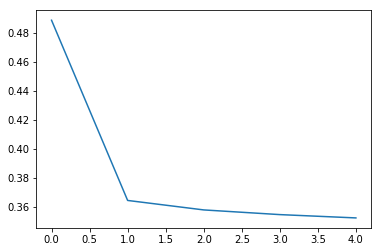

In [27]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size()
        return x.view(N, -1)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.feat = nn.Sequential(
            raise NotImplementedError
        )

    def forward(self, x):
        return self.feat(x)

costs = []
def train(model, loss_fn, optimizer, num_epochs=1):
    for epoch in range(num_epochs):
        cost = 0.0
        for t, (x, y) in enumerate(loader_train):
            if t % 100 == 0:
                print('iter: %d'%(t))
            x_var = Variable(x.type(dtype))
            y_var = Variable(y.type(dtype))

            scores = model(x_var)

            loss = loss_fn(scores, y_var)
            cost += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        costs.append(cost / (t + 1))
        #if (epoch + 1) % (num_epochs / 10) == 0:
        print('Epoch = %d, loss = %.4f' % (epoch + 1, costs[-1]))

model = Model()
model.type(dtype)

lossfn = nn.BCELoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=2e-2)


train(model, lossfn, optimizer, num_epochs=5)
plt.plot(costs)
plt.show()

In [28]:
import numpy as np

true = np.array([])
pred = np.array([])
diff = 0
for t, (x, y) in enumerate(loader_train):
    x_var = Variable(x.type(dtype))
    y_var = Variable(y.type(dtype))

    scores = model(x_var)

    score_numpy = scores.data.numpy().reshape(-1)
    true_numpy = y.numpy().reshape(-1)
    
    score_discrete = score_numpy.copy()
    score_discrete[score_discrete >= 0.5] = 1
    score_discrete[score_discrete < 0.5] = 0
    diff += np.sum(np.abs(score_discrete-true_numpy))
    
    true = np.concatenate((true, true_numpy))
    pred = np.concatenate((pred, score_numpy))

print (diff)

14025.0


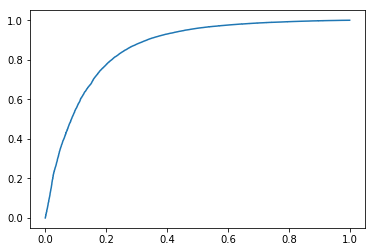

0.86191882140417

In [29]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(true, pred)

plt.plot(fpr, tpr)
plt.show()
metrics.auc(fpr, tpr)

30040 151601
4592.0


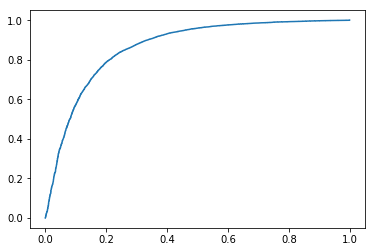

0.8646118888988517

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 58381)
Traceback (most recent call last):
  File "C:\Users\Begongyal\Anaconda3\lib\socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Users\Begongyal\Anaconda3\lib\socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "C:\Users\Begongyal\Anaconda3\lib\socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Users\Begongyal\Anaconda3\lib\socketserver.py", line 696, in __init__
    self.handle()
  File "C:\Users\Begongyal\Anaconda3\lib\site-packages\pyspark\accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "C:\Users\Begongyal\Anaconda3\lib\site-packages\pyspark\serializers.py", line 683, in read_int
    length = stream.read(4)
  File "C:\Users\Begongyal\Anaconda3\lib\socket.py"

In [30]:
import pandas as pd
data_csv = pd.read_csv("Data/truth_test.csv", usecols=[1])
data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')

test_label = dataset.reshape(-1).tolist()

print(len(test_label), len(test_feature))

true = []
pred = []
diff = 0
for t, (x, y) in enumerate(loader_test):
    x_var = Variable(x.type(dtype))
    y_var = Variable(y.type(dtype))

    scores = model(x_var)

    score_numpy = scores.data.numpy().reshape(-1)
    true_numpy = y.numpy().reshape(-1)
    
    score_discrete = score_numpy.copy()
    score_discrete[score_discrete >= 0.5] = 1
    score_discrete[score_discrete < 0.5] = 0
    diff += np.sum(np.abs(score_discrete-true_numpy))
    
    true = np.concatenate((true, true_numpy))
    pred = np.concatenate((pred, score_numpy))

print (diff)

fpr, tpr, thresholds = metrics.roc_curve(true, pred)

plt.plot(fpr, tpr)
plt.show()
metrics.auc(fpr, tpr)

In [ ]:
import pickle

with open("train_feature", 'wb') as f:
    pickle.dump(new_train_feature, f)

with open("train_label", 'wb') as f:
    pickle.dump(train_label, f)
    
with open("test_feature", 'wb') as f:
    pickle.dump(new_test_feature, f)

In [ ]:
with open("train_feature", 'rb') as f:
    file_train = pickle.load(f)
    
with open("train_feature", 'rb') as f:
    file_test = pickle.load(f)